# Deep Learning: final project

## Data loader

### Mount my Drive and then load the package

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


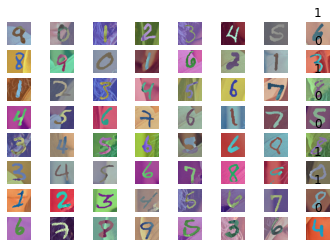

In [25]:
''' This module contains code to handle data '''

import os
import numpy as np
import scipy.ndimage
from PIL import Image
import scipy
import sys
from matplotlib import pyplot as plt


class MnistHandler(object):

    ''' Provides a convenient interface to manipulate MNIST data '''

    def __init__(self):

        # Download data if needed
        self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = self.load_dataset()

        # Load Lena image to memory
        self.lena = Image.open('/content/gdrive/My Drive/Colab Notebooks/CPC/lena.jpeg')

    def load_dataset(self):
        # Credit for this function: https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

        # We first define a download function, supporting both Python 2 and 3.
        if sys.version_info[0] == 2:
            from urllib import urlretrieve
        else:
            from urllib.request import urlretrieve

        def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
            print("Downloading %s" % filename)
            urlretrieve(source + filename, filename)

        # We then define functions for loading MNIST images and labels.
        # For convenience, they also download the requested files if needed.
        import gzip

        def load_mnist_images(filename):
            if not os.path.exists(filename):
                download(filename)
            # Read the inputs in Yann LeCun's binary format.
            with gzip.open(filename, 'rb') as f:
                data = np.frombuffer(f.read(), np.uint8, offset=16)
            # The inputs are vectors now, we reshape them to monochrome 2D images,
            # following the shape convention: (examples, channels, rows, columns)
            data = data.reshape(-1, 1, 28, 28)
            # The inputs come as bytes, we convert them to float32 in range [0,1].
            # (Actually to range [0, 255/256], for compatibility to the version
            # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
            return data / np.float32(256)

        def load_mnist_labels(filename):
            if not os.path.exists(filename):
                download(filename)
            # Read the labels in Yann LeCun's binary format.
            with gzip.open(filename, 'rb') as f:
                data = np.frombuffer(f.read(), np.uint8, offset=8)
            # The labels are vectors of integers now, that's exactly what we want.
            return data

        # We can now download and read the training and test set images and labels.
        X_train = load_mnist_images('train-images-idx3-ubyte.gz')
        y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
        X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
        y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

        # We reserve the last 10000 training examples for validation.
        X_train, X_val = X_train[:-10000], X_train[-10000:]
        y_train, y_val = y_train[:-10000], y_train[-10000:]

        # We just return all the arrays in order, as expected in main().
        # (It doesn't matter how we do this as long as we can read them again.)
        return X_train, y_train, X_val, y_val, X_test, y_test

    def process_batch(self, batch, batch_size, image_size=28, color=False, rescale=True):

        # Resize from 28x28 to 64x64
        if image_size == 64:
            batch_resized = []
            for i in range(batch.shape[0]):
                # resize to 64x64 pixels
                batch_resized.append(scipy.ndimage.zoom(batch[i, :, :], 2.3, order=1))
            batch = np.stack(batch_resized)

        # Convert to RGB
        batch = batch.reshape((batch_size, 1, image_size, image_size))
        batch = np.concatenate([batch, batch, batch], axis=1)

        # Modify images if color distribution requested
        if color:

            # Binarize images
            batch[batch >= 0.5] = 1
            batch[batch < 0.5] = 0

            # For each image in the mini batch
            for i in range(batch_size):

                # Take a random crop of the Lena image (background)
                x_c = np.random.randint(0, self.lena.size[0] - image_size)
                y_c = np.random.randint(0, self.lena.size[1] - image_size)
                image = self.lena.crop((x_c, y_c, x_c + image_size, y_c + image_size))
                image = np.asarray(image).transpose((2, 0, 1)) / 255.0

                # Randomly alter the color distribution of the crop
                for j in range(3):
                    image[j, :, :] = (image[j, :, :] + np.random.uniform(0, 1)) / 2.0

                # Invert the color of pixels where there is a number
                image[batch[i, :, :, :] == 1] = 1 - image[batch[i, :, :, :] == 1]
                batch[i, :, :, :] = image

        # Rescale to range [-1, +1]
        if rescale:
            batch = batch * 2 - 1

        # Channel last
        batch = batch.transpose((0, 2, 3, 1))

        return batch

    def get_batch(self, subset, batch_size, image_size=28, color=False, rescale=True):

        # Select a subset
        if subset == 'train':
            X = self.X_train
            y = self.y_train
        elif subset == 'valid':
            X = self.X_val
            y = self.y_val
        elif subset == 'test':
            X = self.X_test
            y = self.y_test

        # Random choice of samples
        idx = np.random.choice(X.shape[0], batch_size)
        batch = X[idx, 0, :].reshape((batch_size, 28, 28))

        # Process batch
        batch = self.process_batch(batch, batch_size, image_size, color, rescale)

        # Image label
        labels = y[idx]

        return batch.astype('float32'), labels.astype('int32')

    def get_batch_by_labels(self, subset, labels, image_size=28, color=False, rescale=True):

        # Select a subset
        if subset == 'train':
            X = self.X_train
            y = self.y_train
        elif subset == 'valid':
            X = self.X_val
            y = self.y_val
        elif subset == 'test':
            X = self.X_test
            y = self.y_test

        # Find samples matching labels
        idxs = []
        for i, label in enumerate(labels):

            idx = np.where(y == label)[0]
            idx_sel = np.random.choice(idx, 1)[0]
            idxs.append(idx_sel)

        # Retrieve images
        batch = X[np.array(idxs), 0, :].reshape((len(labels), 28, 28))

        # Process batch
        batch = self.process_batch(batch, len(labels), image_size, color, rescale)

        return batch.astype('float32'), labels.astype('int32')

    def get_n_samples(self, subset):

        if subset == 'train':
            y_len = self.y_train.shape[0]
        elif subset == 'valid':
            y_len = self.y_val.shape[0]
        elif subset == 'test':
            y_len = self.y_test.shape[0]

        return y_len


class MnistGenerator(object):

    ''' Data generator providing MNIST data '''

    def __init__(self, batch_size, subset, image_size=28, color=False, rescale=True):

        # Set params
        self.batch_size = batch_size
        self.subset = subset
        self.image_size = image_size
        self.color = color
        self.rescale = rescale

        # Initialize MNIST dataset
        self.mnist_handler = MnistHandler()
        self.n_samples = self.mnist_handler.get_n_samples(subset)
        self.n_batches = self.n_samples // batch_size

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return self.n_batches

    def next(self):

        # Get data
        x, y = self.mnist_handler.get_batch(self.subset, self.batch_size, self.image_size, self.color, self.rescale)

        # Convert y to one-hot
        y_h = np.eye(10)[y]

        return x, y_h


class SortedNumberGenerator(object):

    ''' Data generator providing lists of sorted numbers '''

    def __init__(self, batch_size, subset, terms, positive_samples=1, predict_terms=1, image_size=28, color=False, rescale=True):

        # Set params
        self.positive_samples = positive_samples
        self.predict_terms = predict_terms
        self.batch_size = batch_size
        self.subset = subset
        self.terms = terms
        self.image_size = image_size
        self.color = color
        self.rescale = rescale

        # Initialize MNIST dataset
        self.mnist_handler = MnistHandler()
        self.n_samples = self.mnist_handler.get_n_samples(subset) // terms
        self.n_batches = self.n_samples // batch_size

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return self.n_batches

    def next(self):

        # Build sentences
        image_labels = np.zeros((self.batch_size, self.terms + self.predict_terms))
        sentence_labels = np.ones((self.batch_size, 1)).astype('int32')
        positive_samples_n = self.positive_samples
        for b in range(self.batch_size):

            # Set ordered predictions for positive samples
            seed = np.random.randint(0, 10)
            sentence = np.mod(np.arange(seed, seed + self.terms + self.predict_terms), 10)

            if positive_samples_n <= 0:

                # Set random predictions for negative samples
                # Each predicted term draws a number from a distribution that excludes itself
                numbers = np.arange(0, 10)
                predicted_terms = sentence[-self.predict_terms:]
                for i, p in enumerate(predicted_terms):
                    predicted_terms[i] = np.random.choice(numbers[numbers != p], 1)
                sentence[-self.predict_terms:] = np.mod(predicted_terms, 10)
                sentence_labels[b, :] = 0

            # Save sentence
            image_labels[b, :] = sentence

            positive_samples_n -= 1

        # Retrieve actual images
        images, _ = self.mnist_handler.get_batch_by_labels(self.subset, image_labels.flatten(), self.image_size, self.color, self.rescale)

        # Assemble batch
        images = images.reshape((self.batch_size, self.terms + self.predict_terms, images.shape[1], images.shape[2], images.shape[3]))
        x_images = images[:, :-self.predict_terms, ...]
        y_images = images[:, -self.predict_terms:, ...]

        # Randomize
        idxs = np.random.choice(sentence_labels.shape[0], sentence_labels.shape[0], replace=False)

        return [x_images[idxs, ...], y_images[idxs, ...]], sentence_labels[idxs, ...]


class SameNumberGenerator(object):

    ''' Data generator providing lists of similar numbers '''

    def __init__(self, batch_size, subset, terms, positive_samples=1, predict_terms=1, image_size=28, color=False, rescale=True):

        # Set params
        self.positive_samples = positive_samples
        self.predict_terms = predict_terms
        self.batch_size = batch_size
        self.subset = subset
        self.terms = terms
        self.image_size = image_size
        self.color = color
        self.rescale = rescale

        # Initialize MNIST dataset
        self.mnist_handler = MnistHandler()
        self.n_samples = self.mnist_handler.get_n_samples(subset) // terms
        self.n_batches = self.n_samples // batch_size

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return self.n_batches

    def next(self):

        # Build sentences
        image_labels = np.zeros((self.batch_size, self.terms + self.predict_terms))
        sentence_labels = np.ones((self.batch_size, 1)).astype('int32')
        positive_samples_n = self.positive_samples
        for b in range(self.batch_size):

            # Set positive samples
            seed = np.random.randint(0, 10)
            sentence = seed * np.ones(self.terms + self.predict_terms)

            if positive_samples_n <= 0:

                # Set random predictions for negative samples
                sentence[-self.predict_terms:] = np.mod(sentence[-self.predict_terms:] + np.random.randint(1, 10, self.predict_terms), 10)
                sentence_labels[b, :] = 0

            # Save sentence
            image_labels[b, :] = sentence

            positive_samples_n -= 1

        # Retrieve actual images
        images, _ = self.mnist_handler.get_batch_by_labels(self.subset, image_labels.flatten(), self.image_size, self.color, self.rescale)

        # Assemble batch
        images = images.reshape((self.batch_size, self.terms + self.predict_terms, images.shape[1], images.shape[2], images.shape[3]))
        x_images = images[:, :-self.predict_terms, ...]
        y_images = images[:, -self.predict_terms:, ...]

        # Randomize
        idxs = np.random.choice(sentence_labels.shape[0], sentence_labels.shape[0], replace=False)

        return [x_images[idxs, ...], y_images[idxs, ...]], sentence_labels[idxs, ...]


def plot_sequences(x, y, labels=None, output_path=None):

    ''' Draws a plot where sequences of numbers can be studied conveniently '''

    images = np.concatenate([x, y], axis=1)
    n_batches = images.shape[0]
    n_terms = images.shape[1]
    counter = 1
    for n_b in range(n_batches):
        for n_t in range(n_terms):
            plt.subplot(n_batches, n_terms, counter)
            plt.imshow(images[n_b, n_t, :, :, :])
            plt.axis('off')
            counter += 1
        if labels is not None:
            plt.title(labels[n_b, 0])

    if output_path is not None:
        plt.savefig(output_path, dpi=600)
    else:
        plt.show()


if __name__ == "__main__":

    # Test SortedNumberGenerator
    ag = SortedNumberGenerator(batch_size=8, subset='train', terms=4, positive_samples=4, predict_terms=4, image_size=64, color=True, rescale=False)
    for (x, y), labels in ag:
        plot_sequences(x, y, labels, output_path=r'/content/batch_sample_sorted')
        break


## Benchmark model

In [51]:
sys.path.append('/content/gdrive//My\ Drive/Colab\ Notebooks/CPC')
sys.path.insert(0,'/content/gdrive/My\ Drive/Colab\ Notebooks/CPC')
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/CPC/*.py
!cat '/content/gdrive/My Drive/Colab Notebooks/CPC/data_utils.py'

'/content/gdrive/My Drive/Colab Notebooks/CPC/benchmark_model.py'
'/content/gdrive/My Drive/Colab Notebooks/CPC/data_utils.py'
'/content/gdrive/My Drive/Colab Notebooks/CPC/train_model.py'
''' This module contains code to handle data '''

import os
import numpy as np
import scipy.ndimage
from PIL import Image
import scipy
import sys
from matplotlib import pyplot as plt


class MnistHandler(object):

    ''' Provides a convenient interface to manipulate MNIST data '''

    def __init__(self):

        # Download data if needed
        self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = self.load_dataset()

        # Load Lena image to memory
        self.lena = Image.open('/content/gdrive/My Drive/Colab Notebooks/CPC/lena.jpeg')

    def load_dataset(self):
        # Credit for this function: https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

        # We first define a download function, supporting both Python 2 and 3.
        if sys.version_in

In [29]:
''' This module evaluates the performance of a trained CPC encoder '''

# from data_utils import MnistGenerator
from os.path import join, basename, dirname, exists
import keras
import tensorflow as tf


def build_model(encoder_path, image_shape, learning_rate):

    # Read the encoder
    encoder = keras.models.load_model(encoder_path)

    # Freeze weights
    encoder.trainable = False
    for layer in encoder.layers:
        layer.trainable = False

    # Define the classifier
    x_input = keras.layers.Input(image_shape)
    x = encoder(x_input)
    x = keras.layers.Dense(units=128, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dense(units=10, activation='softmax')(x)

    # Model
    model = keras.models.Model(inputs=x_input, outputs=x)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    model.summary()

    return model


def benchmark_model(encoder_path, epochs, batch_size, output_dir, lr=1e-4, image_size=28, color=False):

    # Prepare data
    train_data = MnistGenerator(batch_size, subset='train', image_size=image_size, color=color, rescale=True)

    validation_data = MnistGenerator(batch_size, subset='valid', image_size=image_size, color=color, rescale=True)

    # Prepares the model
    model = build_model(encoder_path, image_shape=(image_size, image_size, 3), learning_rate=lr)

    # Callbacks
    callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=2, min_lr=1e-4)]

    # Trains the model
    model.fit_generator(
        generator=train_data,
        steps_per_epoch=len(train_data),
        validation_data=validation_data,
        validation_steps=len(validation_data),
        epochs=epochs,
        verbose=1,
        callbacks=callbacks
    )

    # Saves the model
    model.save(join(output_dir, 'supervised.h5'))


if __name__ == "__main__":

    benchmark_model(
        encoder_path='/content/gdrive//My Drive/Colab Notebooks/CPC/models/64x64/encoder.h5',
        epochs=15,
        batch_size=64,
        output_dir='/content/gdrive//My Drive/Colab Notebooks/CPC/models/64x64',
        lr=1e-3,
        image_size=64,
        color=True
    )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 128)               295232    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
781/781 [==============================] - 84s 106ms/step - loss: 0.9708 - categorical_accuracy: 0.6814 - val_loss: 0.7968 - val_categorical_accuracy: 0.7571 - lr: 0.0010
Epoch 2/15
781/781 [==============================] - 80s 102ms/step - loss: 0.8332 - categorical_accuracy: 0.7276 - val_loss: 0.7250 - val_categorical_accuracy: 0.7776 - lr: 0.0010
Epoch 3/15
781/781 [==============================] - 80s 102ms/step - loss: 0.7809 - categorical_accuracy: 0.7448 - val_loss: 0.7118 - val_categorical_accuracy: 0.7727 - lr: 0.0010
Epoch 4/15
781/781 [==============================] - 80s 102ms/step - loss: 0.7629 - categorical_accuracy: 0.7506 - val_loss: 0.6550 - val_categorical_accuracy: 0.8066 - lr: 0.0010
Epoch 5/15
781/781 [==============================] - 80s 102ms/step - loss: 0.7290 - categorical_accuracy: 0.7624 - val_loss: 0.6564 - val_categorical_accuracy: 0.7897 - lr: 0.0010
Epoch 6/15
781/781 [==============================] - 79s 102ms/step - loss: 0.7208 - cate

## Train model

In [45]:
cd content/gdrive/My Drive/CPC/*.py

[Errno 2] No such file or directory: 'content/gdrive/My Drive/CPC/*.py'
/content


In [52]:
'''
This module describes the contrastive predictive coding model from DeepMind:

Oord, Aaron van den, Yazhe Li, and Oriol Vinyals.
"Representation Learning with Contrastive Predictive Coding."
arXiv preprint arXiv:1807.03748 (2018).
'''

from data_utils import SortedNumberGenerator
from os.path import join, basename, dirname, exists
import keras
from keras import backend as K


def network_encoder(x, code_size):

    ''' Define the network mapping images to embeddings '''

    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=256, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dense(units=code_size, activation='linear', name='encoder_embedding')(x)

    return x


def network_autoregressive(x):

    ''' Define the network that integrates information along the sequence '''

    # x = keras.layers.GRU(units=256, return_sequences=True)(x)
    # x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GRU(units=256, return_sequences=False, name='ar_context')(x)

    return x


def network_prediction(context, code_size, predict_terms):

    ''' Define the network mapping context to multiple embeddings '''

    outputs = []
    for i in range(predict_terms):
        outputs.append(keras.layers.Dense(units=code_size, activation="linear", name='z_t_{i}'.format(i=i))(context))

    if len(outputs) == 1:
        output = keras.layers.Lambda(lambda x: K.expand_dims(x, axis=1))(outputs[0])
    else:
        output = keras.layers.Lambda(lambda x: K.stack(x, axis=1))(outputs)

    return output


class CPCLayer(keras.layers.Layer):

    ''' Computes dot product between true and predicted embedding vectors '''

    def __init__(self, **kwargs):
        super(CPCLayer, self).__init__(**kwargs)

    def call(self, inputs):

        # Compute dot product among vectors
        preds, y_encoded = inputs
        dot_product = K.mean(y_encoded * preds, axis=-1)
        dot_product = K.mean(dot_product, axis=-1, keepdims=True)  # average along the temporal dimension

        # Keras loss functions take probabilities
        dot_product_probs = K.sigmoid(dot_product)

        return dot_product_probs

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], 1)


def network_cpc(image_shape, terms, predict_terms, code_size, learning_rate):

    ''' Define the CPC network combining encoder and autoregressive model '''

    # Set learning phase (https://stackoverflow.com/questions/42969779/keras-error-you-must-feed-a-value-for-placeholder-tensor-bidirectional-1-keras)
    K.set_learning_phase(1)

    # Define encoder model
    encoder_input = keras.layers.Input(image_shape)
    encoder_output = network_encoder(encoder_input, code_size)
    encoder_model = keras.models.Model(encoder_input, encoder_output, name='encoder')
    encoder_model.summary()

    # Define rest of model
    x_input = keras.layers.Input((terms, image_shape[0], image_shape[1], image_shape[2]))
    x_encoded = keras.layers.TimeDistributed(encoder_model)(x_input)
    context = network_autoregressive(x_encoded)
    preds = network_prediction(context, code_size, predict_terms)

    y_input = keras.layers.Input((predict_terms, image_shape[0], image_shape[1], image_shape[2]))
    y_encoded = keras.layers.TimeDistributed(encoder_model)(y_input)

    # Loss
    dot_product_probs = CPCLayer()([preds, y_encoded])

    # Model
    cpc_model = keras.models.Model(inputs=[x_input, y_input], outputs=dot_product_probs)

    # Compile model
    cpc_model.compile(
        optimizer=keras.optimizers.Adam(lr=learning_rate),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    cpc_model.summary()

    return cpc_model


def train_model(epochs, batch_size, output_dir, code_size, lr=1e-4, terms=4, predict_terms=4, image_size=28, color=False):

    # Prepare data
    train_data = SortedNumberGenerator(batch_size=batch_size, subset='train', terms=terms,
                                       positive_samples=batch_size // 2, predict_terms=predict_terms,
                                       image_size=image_size, color=color, rescale=True)

    validation_data = SortedNumberGenerator(batch_size=batch_size, subset='valid', terms=terms,
                                            positive_samples=batch_size // 2, predict_terms=predict_terms,
                                            image_size=image_size, color=color, rescale=True)

    # Prepares the model
    model = network_cpc(image_shape=(image_size, image_size, 3), terms=terms, predict_terms=predict_terms,
                        code_size=code_size, learning_rate=lr)

    # Callbacks
    callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=2, min_lr=1e-4)]

    # Trains the model
    model.fit_generator(
        generator=train_data,
        steps_per_epoch=len(train_data),
        validation_data=validation_data,
        validation_steps=len(validation_data),
        epochs=epochs,
        verbose=1,
        callbacks=callbacks
    )

    # Saves the model
    # Remember to add custom_objects={'CPCLayer': CPCLayer} to load_model when loading from disk
    model.save(join(output_dir, 'cpc.h5'))

    # Saves the encoder alone
    encoder = model.layers[1].layer
    encoder.save(join(output_dir, 'encoder.h5'))


if __name__ == "__main__":

    train_model(
        epochs=10,
        batch_size=32,
        output_dir='models/64x64',
        code_size=128,
        lr=1e-3,
        terms=4,
        predict_terms=4,
        image_size=64,
        color=True
    )


HTTPError: ignored